In [1]:
import numpy  as np
import time
import pandas as pd                     
from   math   import radians as DegToRad       # Degrees to radians Conversion

from shapely.geometry import Point             # Imported for constraint checking
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore")

def getTurbLoc(turb_loc_file_name):
    
    df = pd.read_csv(turb_loc_file_name, sep=',', dtype = np.float32)
    turb_coords = df.to_numpy(dtype = np.float32)
    return(turb_coords)


def loadPowerCurve(power_curve_file_name):
    powerCurve = pd.read_csv(power_curve_file_name, sep=',', dtype = np.float32)
    powerCurve = powerCurve.to_numpy(dtype = np.float32)
    return(powerCurve)
    

def binWindResourceData(wind_data_file_name):
    
    # Load wind data. Then, extracts the 'drct', 'sped' columns
    df = pd.read_csv(wind_data_file_name)
    wind_resource = df[['drct', 'sped']].to_numpy(dtype = np.float32)
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1

    
    # placeholder for binned wind
    binned_wind = np.zeros((n_slices_drct, n_slices_sped), 
                           dtype = np.float32)
    
    # 'trap' data points inside the bins. 
    for i in range(n_slices_drct):
        for j in range(n_slices_sped):     
            
            # because we already have drct in the multiples of 10
            foo = wind_resource[(wind_resource[:,0] == slices_drct[i])] 

            foo = foo[(foo[:,1] >= slices_sped[j]) 
                          & (foo[:,1] <  slices_sped[j+1])]
            
            binned_wind[i,j] = foo.shape[0]  
    
    wind_inst_freq   = binned_wind/np.sum(binned_wind)
    wind_inst_freq   = wind_inst_freq.ravel()
    
    return(wind_inst_freq)


def searchSorted(lookup, sample_array):
    lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
    idx1 = np.searchsorted(lookup_middles, sample_array)
    indices = np.arange(lookup.shape[0])[idx1]
    return indices

   

def preProcessing(power_curve):
    # number of turbines
    n_turbs       =   50
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1
    
    # number of wind instances
    n_wind_instances = (n_slices_drct)*(n_slices_sped)
    
    # Create wind instances. There are two columns in the wind instance array
    # First Column - Wind Speed. Second Column - Wind Direction
    # Shape of wind_instances (n_wind_instances,2). 
    # Values [1.,360.],[3.,360.],[5.,360.]...[25.,350.],[27.,350.],29.,350.]
    wind_instances = np.zeros((n_wind_instances,2), dtype=np.float32)
    counter = 0
    for i in range(n_slices_drct):
        for j in range(n_slices_sped): 
            
            wind_drct =  slices_drct[i]
            wind_sped = (slices_sped[j] + slices_sped[j+1])/2
            
            wind_instances[counter,0] = wind_sped
            wind_instances[counter,1] = wind_drct
            counter += 1

	# So that the wind flow direction aligns with the +ve x-axis.			
    # Convert inflow wind direction from degrees to radians
    wind_drcts =  np.radians(wind_instances[:,1] - 90)
    # For coordinate transformation 
    cos_dir = np.cos(wind_drcts).reshape(n_wind_instances,1)
    sin_dir = np.sin(wind_drcts).reshape(n_wind_instances,1)
    
    # create copies of n_wind_instances wind speeds from wind_instances
    wind_sped_stacked = np.column_stack([wind_instances[:,0]]*n_turbs)
   
    # Pre-prepare matrix with stored thrust coeffecient C_t values for 
    # n_wind_instances shape (n_wind_instances, n_turbs, n_turbs). 
    # Value changing only along axis=0. C_t, thrust coeff. values for all 
    # speed instances.
    # we use power_curve data as look up to estimate the thrust coeff.
    # of the turbine for the corresponding closest matching wind speed
    indices = searchSorted(power_curve[:,0], wind_instances[:,0])
    C_t     = power_curve[indices,1]
    # stacking and reshaping to assist vectorization
    C_t     = np.column_stack([C_t]*(n_turbs*n_turbs))
    C_t     = C_t.reshape(n_wind_instances, n_turbs, n_turbs)
    
    return(n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)


def getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
            n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,n):
    
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
    
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    
    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    
    # Estimate power from power_curve look up for wind_sped_eff
    indices = searchSorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    # Farm power for single wind instance 
    power_n = power[:,n]
    p_min = 12
    min_pos = -1
    for i in range(50):
        pov = power[:,i]
        pov1 = np.sum(pov*wind_inst_freq)
        if(pov1<p_min):
            p_min = pov1
            min_pos = i
    power   = np.sum(power, axis=1)
    
    
    # multiply the respective values with the wind instance probabilities 
    # year_hours = 8760.0
    AEP = 8760.0*np.sum((power*wind_inst_freq))
    n_aep = 8760*np.sum(power_n*wind_inst_freq)
    
    # Convert MWh to GWh
    AEP = AEP/1e3
    n_aep = n_aep/1e3
    
    return n_aep, AEP, min_pos
    

    
def checkConstraints(turb_coords, turb_diam):
    bound_clrnc      = 50
    prox_constr_viol = False
    peri_constr_viol = False
    
    # create a shapely polygon object of the wind farm
    farm_peri = [(0, 0), (0, 4000), (4000, 4000), (4000, 0)]
    farm_poly = Polygon(farm_peri)
    
    # checks if for every turbine perimeter constraint is satisfied. 
    # breaks out if False anywhere
    for turb in turb_coords:
        turb = Point(turb)
        inside_farm   = farm_poly.contains(turb)
        correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
        if (inside_farm == False or correct_clrnc == False):
            peri_constr_viol = True
            break
    
    # checks if for every turbines proximity constraint is satisfied. 
    # breaks out if False anywhere
    for i,turb1 in enumerate(turb_coords):
        for turb2 in np.delete(turb_coords, i, axis=0):
            if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                prox_constr_viol = True
                break
    
    # print messages
    if  peri_constr_viol  == True  and prox_constr_viol == True:
          return 1
    elif peri_constr_viol == True  and prox_constr_viol == False:
          return 2
    elif peri_constr_viol == False and prox_constr_viol == True:
          return 3
    else: return 4 
def main(turb_coords,pcloc,windloc,n):
    turb_specs    =  {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                     }
    turb_diam      =  turb_specs['Dia (m)']
    turb_rad       =  turb_diam/2 
    power_curve   =  loadPowerCurve(pcloc)
    wind_inst_freq =  binWindResourceData(windloc)   
    n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)
    con = checkConstraints(turb_coords, turb_diam)
    #print(con)
    #print('Calculating AEP......')
    nAEP, AEP, p_min = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,n) 
    #print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')
    return con,nAEP, AEP , p_min
turbloc = '../input/shell-hackathon/Shell_Hackathon Dataset/turbine_loc_test.csv'
pcloc = '../input/shell-hackathon/Shell_Hackathon Dataset/power_curve.csv'
windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'

def find(arr1,arr2):
    for i in arr1:
        if(i==arr2):
            return True ;
    return False

In [2]:
res6 = np.array(pd.read_csv('../input/3894-best/submissioncool2007.csv'))

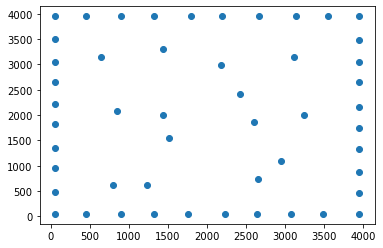

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Creating a numpy array
X = res6[:,0]
Y = res6[:,1]
# Plotting point using sactter method
plt.scatter(X,Y)
plt.show()

In [4]:
value , naep, aep1, pmin = main(res6,pcloc,windloc,10)
res6c = res6.copy()
print(aep1)
resfinal = res6c.copy()
aepfinal = aep1

538.9582447814942


In [5]:
windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2017.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (41):
        x1 = maxx-20+i
        if(x1<50 or x1>3950):
            continue
        for j in range(41):
            y1 = maxy-20+j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissiol2007.csv',index = False)

0
4 577.6734521484375
1
4 577.7021905517578
2
4 577.7029925537109
3
4 577.7029925537109
4
4 577.7029925537109
5
4 577.7029925537109
6
4 577.7029925537109
7
4 577.7029925537109
8
4 577.7146215820312
9
4 577.7146215820312
10
4 577.7146215820312
11
4 577.7146215820312
12
4 577.7146215820312
13
4 577.7146215820312
14
4 577.7146215820312
15
4 577.7192999267578
16
4 577.7192999267578
17
4 577.7192999267578
18
4 577.730126953125
19
4 577.730126953125
20
4 577.7302606201172
21
4 577.7666180419922
22
4 577.7868017578126
23
4 577.7868017578126
24
4 577.7868017578126
25
4 577.7880047607422
26
4 577.7880047607422
27
4 577.7880047607422
28
4 577.7904107666016
29
4 577.8143371582031
30
4 577.815673828125
31
4 577.815673828125
32
4 577.815673828125
33
4 577.816408996582
34
4 577.816408996582
35
4 577.816408996582
36
4 577.8166094970703
37
4 577.8172778320312
38
4 577.8172778320312
39
4 577.8172778320312
40
4 577.8192828369141
41
4 577.8192828369141
42
4 577.8192828369141
43
4 577.8192828369141
44
4 5

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2008.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)
windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2008.csv',index = False)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2009.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)


windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2009.csv',index = False)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2013.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)


windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2013.csv',index = False)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2014.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2014.csv',index = False)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2015.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(y1<50 or y1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2015.csv',index = False)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2017.csv'
store_min = []
for minind in range(50) :
    refaep = aep1
    print(minind)
    maxx = res6c[minind][0]
    maxy = res6c[minind][1]
    for i in range (21):
        x1 = maxx-20+2*i
        if(x1<50 or x1>3950):
            continue
        for j in range(21):
            y1 = maxy-20+2*j
            if(x1<50 or x1>3950):
                continue
            res6c[minind] = [x1,y1]
            value ,naep, aep1, _ = main(res6c,pcloc,windloc,minind)
            if(aep1>refaep and value == 4):
                maxx = x1
                maxy = y1
                refaep = aep1
    res6c[minind] = [maxx,maxy]
    value , naep, aep1,_ = main(res6c,pcloc,windloc,10)
    print(value,aep1)

windloc = '../input/shell-hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv'
value , naep, aep1, pmin = main(res6c,pcloc,windloc,10)
print(aep1)
df = pd.DataFrame(res6c, columns = ['x','y'])
df.to_csv('submissioncool2017.csv',index = False)